In [289]:
# import all required tools
import pandas as pd
import os
import shutil

In [290]:
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [291]:

from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [292]:
# reading the csv files as dataframes using pandas function read_csv
meta_df = pd.read_csv('D:\\ISIC_2019_Training_Metadata_no_null.csv')
skin_df = pd.read_csv('D:\\ISIC_2019_Training_GroundTruth_no_null.csv')
# Dump all images into a folder and specify the path:
data_dir = "D:\\ISIC_2019_Training_Input\\ISIC_2019_Training_Input\\"

In [293]:
# 8 labels for data
labels = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC']

In [295]:
# for creating label data for classification
j = 0
for index,row in skin_df.iterrows():
    k = 0
    for i in labels:
        if(row[str(i)]==1):
            skin_df.loc[index, 'label'] = k
        k = k + 1

In [296]:
skin_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0012653_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ISIC_0012654_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ISIC_0012655_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,ISIC_0012656_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ISIC_0012657_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
21306,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
21307,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
21308,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21309,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [301]:
# merging the label column with meta data
meta_df = pd.merge(meta_df,skin_df[['image','label']],on='image',how='right')

In [191]:
# writing the new datafrme with labels into csv
meta_df.to_csv('D:\\ISIC_2019_Training_Metadata_no_null.csv',index=False)

In [303]:
SIZE = 32 # resizing image to 32 * 32 

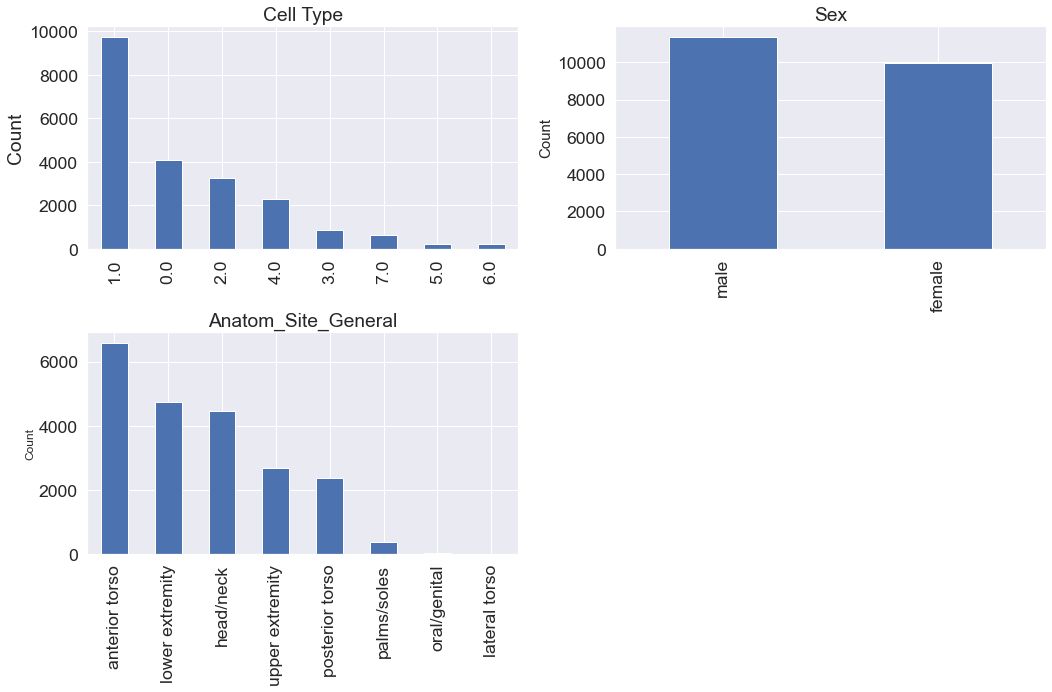

In [304]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
meta_df['label'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
meta_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
meta_df['anatom_site_general'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Anatom_Site_General')


plt.tight_layout()
plt.show()

In [305]:
# balancing the dataframes 
df_0 = meta_df[meta_df['label'] == 0]
df_1 = meta_df[meta_df['label'] == 1]
df_2 = meta_df[meta_df['label'] == 2]
df_3 = meta_df[meta_df['label'] == 3]
df_4 = meta_df[meta_df['label'] == 4]
df_5 = meta_df[meta_df['label'] == 5]
df_6 = meta_df[meta_df['label'] == 6]
df_7 = meta_df[meta_df['label'] == 7]

n_samples=400 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=30) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=30) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=30)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=30)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=30)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=30)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=30)
df_7_balanced = resample(df_7, replace=True, n_samples=n_samples, random_state=30)

meta_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, 
                              df_6_balanced, df_7_balanced])

In [306]:
j = 0
for index,row in meta_df_balanced.iterrows():
    meta_df_balanced.loc[index, 'path'] = data_dir + meta_df['image'][index] + '.jpg'

In [308]:
meta_df_balanced = meta_df_balanced.dropna()


In [309]:
meta_df_balanced['image_arr'] = meta_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [283]:

#Convert dataframe column of images into numpy array
X = np.asarray(meta_df_balanced['image_arr'].tolist())
X = X/255.  # Scale values to 0-1
Y=meta_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=8) #Convert to categorical as this is a multiclass classification problem


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)         

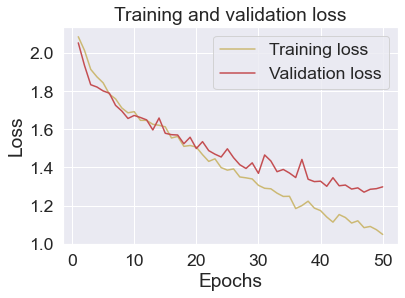

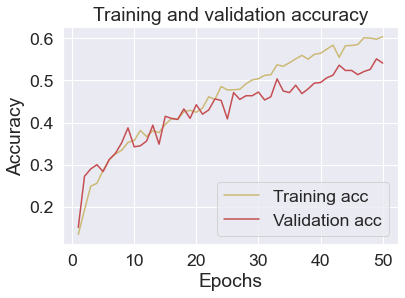

Text(25.5, 0.5, 'Fraction of incorrect predictions')

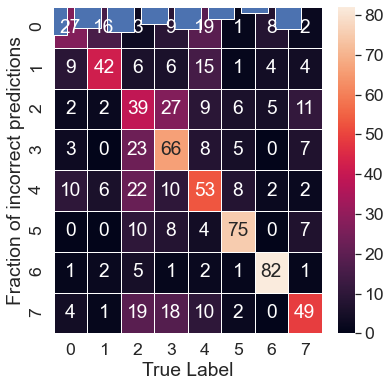

In [311]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=30)

#Define the model.

num_classes = 8

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(8, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(8), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
